What You're Aiming For

In this checkpoint, we are going to work on the 'Credit Card Dataset for Clustering' dataset provided by Kaggle.

Dataset description : This dataset was derived and simplified for learning purposes. It includes usage behaviour of about 9000 active credit card holders during 6 months period. This case requires to develop a customer segmentation to define marketing strategy.

➡️ Dataset link 

https://i.imgur.com/gAT5gVg.jpg

Columns explanation : 

CUST_ID: Identification of Credit Card holder (Categorical)
BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
PURCHASES: Amount of purchases made from account 
CASH_ADVANCE: Cash in advance given by the user
CREDIT_LIMIT: Limit of Credit Card for user 
PAYMENTS: Amount of Payment done by user 

Instructions

Import you data and perform basic data exploration phase
Perform the necessary data preparation steps ( Corrupted and missing values handling, data encoding, outliers handling ... )
Perform hierarchical clustering to identify the inherent groupings within your data. Then, plot the clusters. (use only 2 features. For example, try to cluster the customer base with respect to 'PURCHASES' and 'credit limit')
Perform partitional clustering using the K-means algorithm. Then, plot the clusters
Find the best k value and plot the clusters again.
Interpret the results

In [71]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [72]:
# Import necessary libraries
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
import seaborn as sns  # Import Seaborn for enhanced plotting capabilities
from sklearn.cluster import KMeans  # Import KMeans from scikit-learn for clustering
from sklearn.preprocessing import StandardScaler  # Import StandardScaler from scikit-learn for data scaling

In [73]:
# Load the dataset (Mall Customer Segmentation Data)

data = pd.read_csv("Credit_card_dataset.csv")

# Inspect the first few rows of the dataset to understand its structure
data.head()

,CUST_ID,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
0,C10001,0.818182,95.40,201.802084,1000.0,0.000000
1,C10002,0.909091,0.00,4103.032597,7000.0,6442.945483
2,C10003,1.000000,773.17,622.066742,7500.0,0.000000
3,C10004,0.636364,1499.00,0.000000,7500.0,205.788017
4,C10005,1.000000,16.00,678.334763,1200.0,0.000000


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CUST_ID            8950 non-null   object 
 1   BALANCE_FREQUENCY  8950 non-null   float64
 2   PURCHASES          8950 non-null   float64
 3   PAYMENTS           8950 non-null   float64
 4   CREDIT_LIMIT       8949 non-null   float64
 5   CASH_ADVANCE       8950 non-null   float64
dtypes: float64(5), object(1)
memory usage: 419.7+ KB


In [75]:
print(data.isnull().sum())

CUST_ID              0
BALANCE_FREQUENCY    0
PURCHASES            0
PAYMENTS             0
CREDIT_LIMIT         1
CASH_ADVANCE         0
dtype: int64


In [76]:
# Handle missing values by filling the single missing value in 'CREDIT_LIMIT' with the median
data['CREDIT_LIMIT'].fillna(data['CREDIT_LIMIT'].median(), inplace=True)

# Display summary statistics to explore the distribution of the numeric features
data.describe()

,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,0.877271,1003.204834,1733.143852,4494.282473,978.871112
std,0.236904,2136.634782,2895.063757,3638.646702,2097.163877
min,0.000000,0.000000,0.000000,50.000000,0.000000
25%,0.888889,39.635000,383.276166,1600.000000,0.000000
50%,1.000000,361.280000,856.901546,3000.000000,0.000000
75%,1.000000,1110.130000,1901.134317,6500.000000,1113.821139
max,1.000000,49039.570000,50721.483360,30000.000000,47137.211760


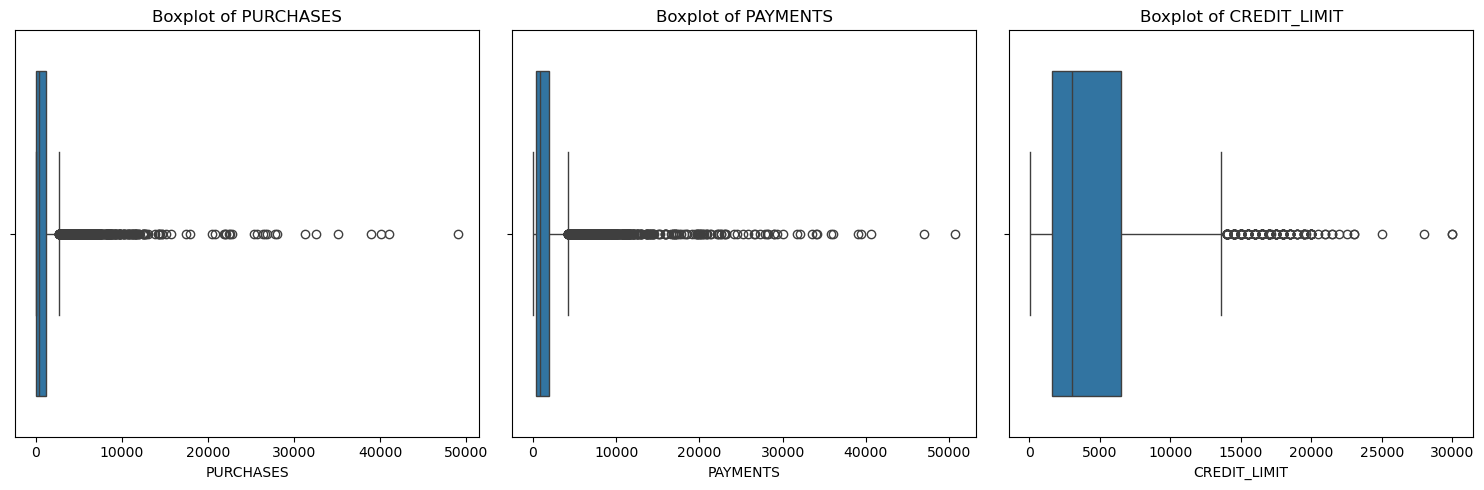

In [77]:
# Now we are done with missing values, lets check for outliers
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting boxplots for PURCHASES, PAYMENTS, and CREDIT_LIMIT
plt.figure(figsize=(15, 5))

# Boxplot for PURCHASES
plt.subplot(1, 3, 1)
sns.boxplot(x=data['PURCHASES'])
plt.title('Boxplot of PURCHASES')

# Boxplot for PAYMENTS
plt.subplot(1, 3, 2)
sns.boxplot(x=data['PAYMENTS'])
plt.title('Boxplot of PAYMENTS')

# Boxplot for CREDIT_LIMIT
plt.subplot(1, 3, 3)
sns.boxplot(x=data['CREDIT_LIMIT'])
plt.title('Boxplot of CREDIT_LIMIT')

plt.tight_layout()
plt.show()

In [78]:
# There are alot of outliers so we can decide to either Cap or remove the outliers. I will proceed by capping those outliers
def cap_outliers(data_column, lower_percentile=0.05, upper_percentile=0.95):
    lower_bound = data_column.quantile(lower_percentile)
    upper_bound = data_column.quantile(upper_percentile)
    return np.clip(data_column, lower_bound, upper_bound)

data_capped = data.copy()
data_capped['PURCHASES'] = cap_outliers(data_capped['PURCHASES'])
data_capped['PAYMENTS'] = cap_outliers(data_capped['PAYMENTS'])
data_capped['CREDIT_LIMIT'] = cap_outliers(data_capped['CREDIT_LIMIT'])

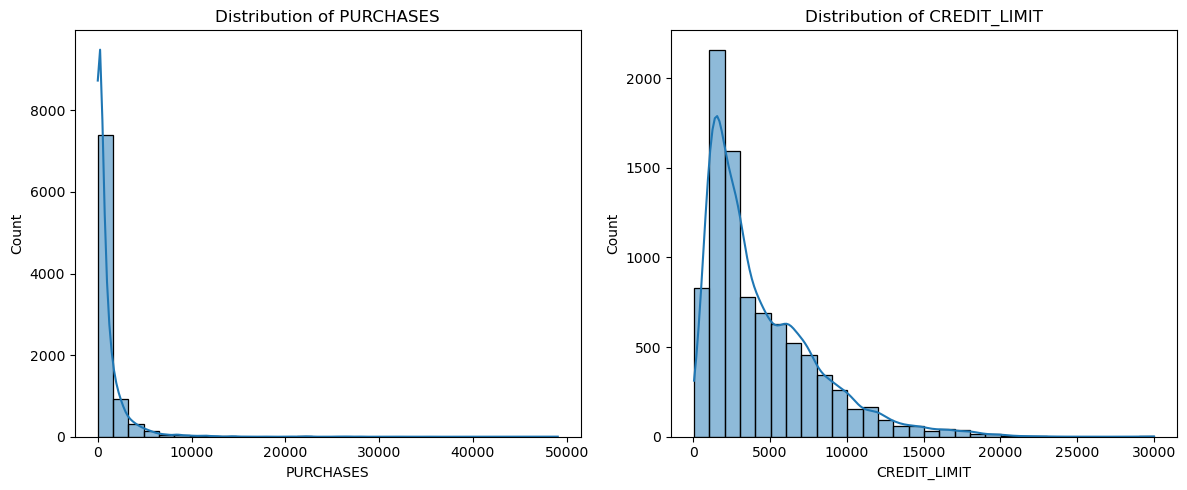

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of 'PURCHASES' and 'CREDIT_LIMIT'
plt.figure(figsize=(12, 5))

# Distribution of PURCHASES
plt.subplot(1, 2, 1)
sns.histplot(data['PURCHASES'], bins=30, kde=True)
plt.title('Distribution of PURCHASES')

# Distribution of CREDIT_LIMIT
plt.subplot(1, 2, 2)
sns.histplot(data['CREDIT_LIMIT'], bins=30, kde=True)
plt.title('Distribution of CREDIT_LIMIT')

plt.tight_layout()
plt.show()

In [80]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

In [81]:
# Select the two features for clustering
X = data[['PURCHASES', 'CREDIT_LIMIT']]

In [82]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

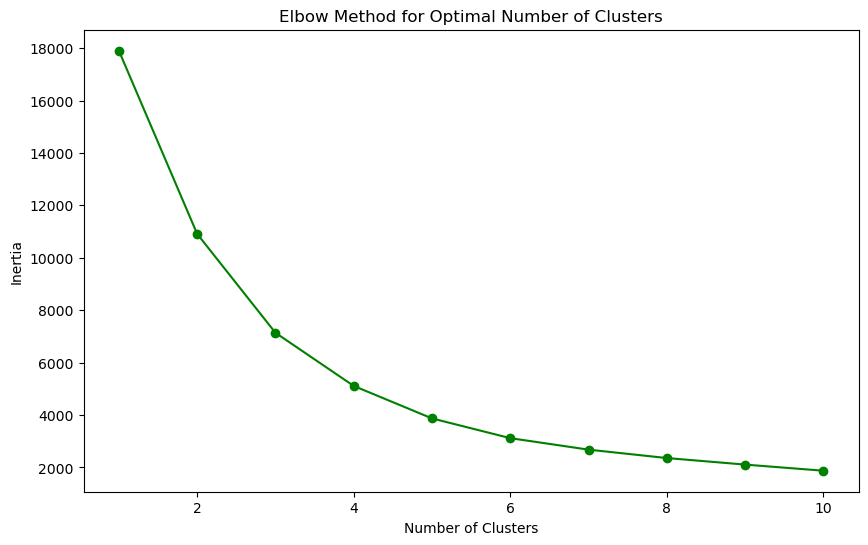

In [83]:
inertia = []  # List to store the inertia values for each number of clusters

for i in range(1, 11):  # Loop over cluster numbers from 1 to 10
    kmeans = KMeans(n_clusters=i, random_state=42)  # Initialize KMeans with the current number of clusters (i)
    kmeans.fit(X_scaled)  # Fit the KMeans model on the standardized data
    inertia.append(kmeans.inertia_)  # Append the inertia (sum of squared distances) to the list

# Plot the Elbow curve
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.plot(range(1, 11), inertia, 'go-')  # Plot the number of clusters against inertia with red markers and lines
# 'r': Specifies the color of the plot, in this case, red (r stands for red).
# 'o': Specifies the marker style, which in this case is a circle (o).
# '-': Specifies the line style, which in this case is a solid line (-).

plt.title('Elbow Method for Optimal Number of Clusters')  # Add a title to the plot
plt.xlabel('Number of Clusters')  # Label the x-axis as 'Number of Clusters'
plt.ylabel('Inertia')  # Label the y-axis as 'Inertia' (within-cluster sum of squares)
plt.show()  # Display the plot

In [84]:
# Fit K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)  # Initialize the KMeans algorithm with 5 clusters and a fixed random state for reproducibility
kmeans.fit(X_scaled)  # Fit the KMeans model to the standardized data

KMeans(n_clusters=5, random_state=42)

In [85]:
kmeans.inertia_

3871.328156336417

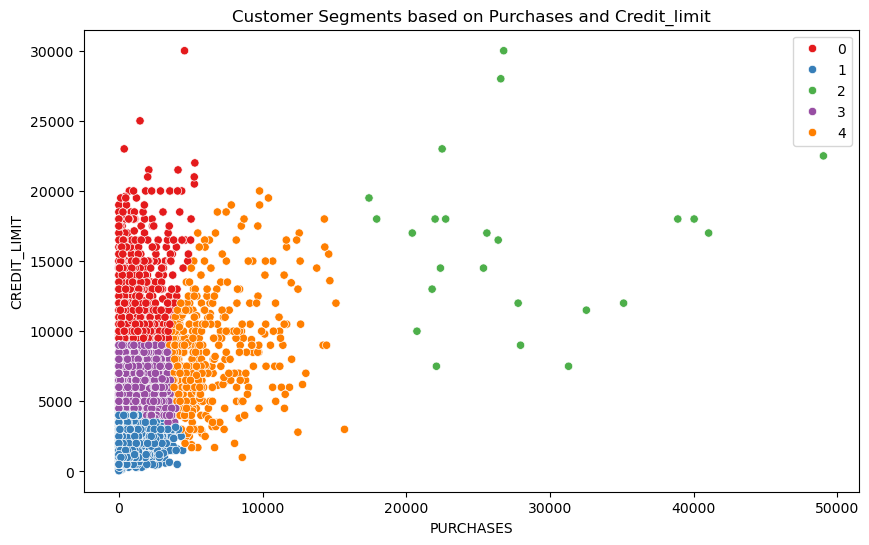

In [86]:
data['Cluster'] = kmeans.labels_  # Assign the cluster labels from the KMeans model to a new column 'Cluster' in the dataset

# Visualize the clusters using a scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
sns.scatterplot(x=data['PURCHASES'], y=data['CREDIT_LIMIT'], hue=data['Cluster'], palette='Set1')  
# Create a scatter plot with 'PURCHASES' on the x-axis, 'CREDIT_LIMIT' on the y-axis, and color the points by their cluster labels
plt.title('Customer Segments based on Purchases and Credit_limit')  # Add a title to the plot
plt.xlabel('PURCHASES')  # Label the x-axis
plt.ylabel('CREDIT_LIMIT')  # Label the y-axis
plt.legend()  # Display the legend showing the clusters
plt.show()  # Show the plot

In [87]:
data["Cluster"].value_counts()

Cluster
1    5245
3    2476
0     771
4     434
2      24
Name: count, dtype: int64

### Hierarchical 

In [89]:
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for normalizing or scaling features before clustering
from sklearn.cluster import AgglomerativeClustering  # Import AgglomerativeClustering for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage  # 

In [90]:
# Use scipy's linkage method to perform hierarchical/agglomerative clustering
# 'ward' is the linkage method that minimizes variance within clusters
linked = linkage(X_scaled, method='ward')

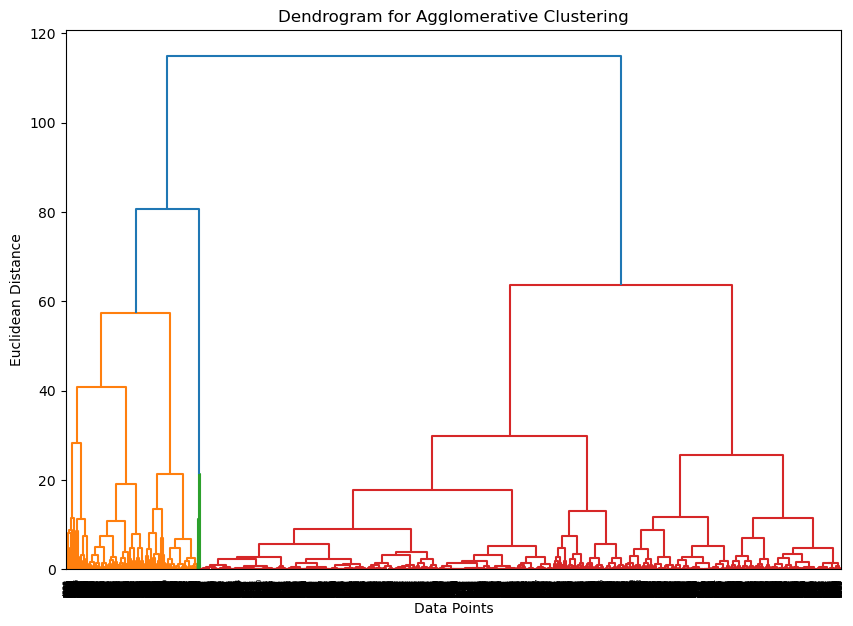

In [91]:
# Create a new figure with a specific size for the dendrogram
plt.figure(figsize=(10, 7))

# Plot the dendrogram using the linkage matrix (linked), where:
# - orientation='top' means the root of the dendrogram will be at the top.
# - distance_sort='descending' sorts clusters by descending distances between them.
# - show_leaf_counts=True will display the number of points in each cluster.
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)

# Add a title to the plot to describe it as a dendrogram for agglomerative clustering
plt.title('Dendrogram for Agglomerative Clustering')

# Label the x-axis as 'Data Points' since the horizontal axis represents the individual data points or clusters
plt.xlabel('Data Points')

# Label the y-axis as 'Euclidean Distance' because the vertical axis represents the distance between merged clusters
plt.ylabel('Euclidean Distance')

# Display the plot
plt.show()

In [92]:
# Perform agglomerative clustering with the following parameters:
# - n_clusters=4: Specifies that we want to group the data into 4 clusters.
# - metric='euclidean': Specifies that the Euclidean distance will be used to measure the similarity between data points.
# - linkage='ward': Specifies that Ward’s method will be used to minimize the variance within clusters when merging them.
agglom = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')

In [93]:
# Fit and predict the clusters
clusters = agglom.fit_predict(X_scaled)

In [94]:
# Add cluster labels to the original dataset
data['Cluster'] = clusters

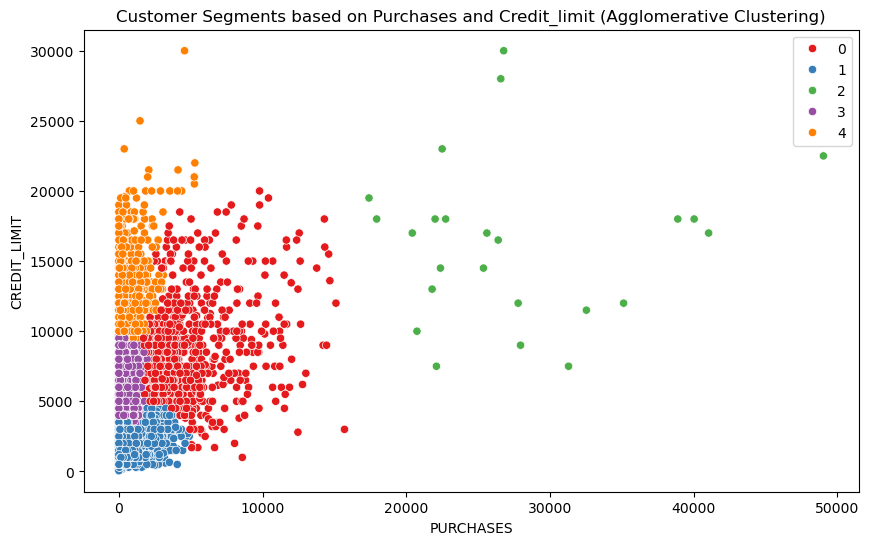

In [95]:
# Visualize the clusters using a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['PURCHASES'], y=data['CREDIT_LIMIT'], hue=data['Cluster'], palette='Set1')
plt.title('Customer Segments based on Purchases and Credit_limit (Agglomerative Clustering)')
plt.xlabel('PURCHASES')
plt.ylabel('CREDIT_LIMIT')
plt.legend()
plt.show()

The scatter plot shows the clusters identified by the Agglomerative Clustering algorithm based on purchases and credit limit